# Analysis of Fires >200 Hectares in Canada: Impact of Climate Indices

## By: Garrick Hague

### Introduction

Wildfires have become increasingly prevalent and severe in recent years, posing significant challenges to ecosystems, communities, and economies worldwide. In Canada, where vast forested regions are susceptible to fire, understanding the factors driving these events is crucial for effective management and mitigation strategies.

This Jupyter Notebook presents an in-depth analysis of wildfires exceeding 200 hectares in Canada, focusing on their relationship with key climate indices such as the El Niño-Southern Oscillation (ENSO) and the Pacific Decadal Oscillation (PDO). By merging comprehensive fire data with climate indices, we aim to unravel the intricate interplay between climatic patterns and wildfire occurrence.

### Dataset

The primary dataset utilized in this analysis is sourced from the Canadian Wildland Fire Information System (CWFIS), providing detailed records of wildfires exceeding 200 hectares. Due to its extensive size (1.47 Gigabits), the dataset cannot be hosted directly on GitHub. However, the data can be accessed and downloaded from the provided link: [Wildfire Dataset](https://cwfis.cfs.nrcan.gc.ca/datamart/download/nfdbpoly)

### Methodology

To investigate the relationship between wildfires and climate indices, advanced machine learning techniques were employed. Specifically, we utilized the scikit-learn (Sklearn) library to construct and evaluate several regression models, including:

1. Linear Regression
2. Random Forest Regressor
3. HistGradientBoosting Regressor

To optimize model performance, a grid search was conducted, leveraging 5-fold cross-validation and the coefficient of determination (R^2) metric to identify the most effective parameters.

### Objective

Through this analysis, we aim to achieve the following objectives:

- Assess the impact of climate indices on wildfire occurrence and severity.
- Identify significant predictors of wildfires exceeding 200 hectares.
- Develop accurate predictive models to enhance wildfire risk assessment and management strategies.

### Notebook Structure

1. [Data Exploration](#data-preprocessing): Exploration, data processing and feature engineering.
2. [Exploratory Data Analysis](#eda): Visualizing patterns and relationships between variables.
3. [Model Construction](#model-construction): Building regression models using Sklearn.
4. [Model Evaluation](#model-evaluation): Assessing model performance and identifying optimal parameters.
5. [Conclusion](#conclusion): Summary of findings and implications for wildfire management.

By delving into the complex dynamics between climate indices and wildfires, this analysis strives to provide valuable insights in mitigating the impact of wildfires on Canadian landscapes and communities.

### Importing Needed Libraries

In [1]:
import numpy as np 
import pandas as pd 
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import warnings
# Set display options to show all columns
pd.set_option('display.max_columns', None)

# Disable the warning
warnings.filterwarnings('ignore')

### Loading in the datasets

In [2]:
# Loading in fire data
gdf = gpd.read_file('/Users/garrickhague/Desktop/Classes/ATMS_523/fire_data/NFDB_poly_large_fires/NFDB_poly_20210707_large_fires.shp')

In [3]:
# Loading in the climate indices
enso = pd.read_csv('https://www.esrl.noaa.gov/psd/data/correlation/censo.data',delim_whitespace=True,header=None,skiprows=1,skipfooter=2, engine='python')
pdo = pd.read_csv('https://www.esrl.noaa.gov/psd/data/correlation/pdo.data',delim_whitespace=True,header=None,skiprows=1,skipfooter=14, engine='python')


### Processing ENSO and PDO data so that they are organized into columns and then merged together

In [4]:
# Dropping extra rows not needed
enso.drop(75, inplace=True)

# Creating empty dataframes
enso_new=pd.DataFrame()    
pdo_new=pd.DataFrame()

# Creating range of dates from 1948-2022
enso_new['Date']=pd.date_range(start=pd.Timestamp(1948,1,1),end=pd.Timestamp(2022,12,1),freq="MS")
pdo_new['Date']=pd.date_range(start=pd.Timestamp(1948,1,1),end=pd.Timestamp(2022,12,1),freq="MS")

# Extracting and assigning values to new DataFrames
len(enso.loc[:,1:].stack().values)
len(pdo.loc[:,1:].stack().values)

# Extracting and assigning values to new DataFrames
enso_new['ENSO']=enso.loc[:,1:].stack().values
pdo_new['PDO']=pdo.loc[:,1:].stack().values

# Converting 'Date' column to period format
enso_new['Date'] = enso_new['Date'].dt.to_period('M')
pdo_new['Date'] = pdo_new['Date'].dt.to_period('M')

# Merge teleconnections
merged_df = pd.merge(enso_new, pdo_new, on='Date')


<a id="data-preprocessing"></a>

## Data Exploration

In [5]:
# Printing 5 rows in dataframe
gdf.head()

,SRC_AGENCY,FIRE_ID,FIRENAME,YEAR,MONTH,DAY,REP_DATE,DATE_TYPE,OUT_DATE,DECADE,SIZE_HA,CALC_HA,CAUSE,MAP_SOURCE,SOURCE_KEY,MAP_METHOD,WATER_REM,UNBURN_REM,MORE_INFO,POLY_DATE,CFS_REF_ID,CFS_NOTE1,CFS_NOTE2,AG_SRCFILE,ACQ_DATE,SRC_AGY2,geometry
0,BC,2004-C10175,None,2004,6,23,2004-06-23,Report date,None,2000-2009,1370.5,1370.507344,L,Satellite imagery,LANDSAT5,digitized,None,None,None,2007-05-17,BC-2004-C10175,None,None,H_FIRE_PLY,2011-06-10,BC,"POLYGON Z ((-1886926.467 898021.006 0.000, -18..."
1,BC,2004-C10176,None,2004,6,23,2004-06-23,Report date,None,2000-2009,520.7,520.796287,L,Satellite imagery,LANDSAT5,digitized,None,None,None,2007-05-17,BC-2004-C10176,None,None,H_FIRE_PLY,2011-06-10,BC,"POLYGON Z ((-1880308.251 892344.865 0.000, -18..."
2,BC,2004-C50114,None,2004,6,20,2004-06-20,Report date,None,2000-2009,268.2,268.290572,L,Satellite imagery,LANDSAT5,digitized,None,None,None,2007-05-17,BC-2004-C50114,None,None,H_FIRE_PLY,2011-06-10,BC,"POLYGON Z ((-1965048.293 820512.199 0.000, -19..."
3,BC,2004-C50125,None,2004,6,21,2004-06-21,Report date,None,2000-2009,20506.4,20506.415129,L,Satellite imagery,LANDSAT5,Modified from Protection,None,None,None,2007-05-17,BC-2004-C50125,None,None,H_FIRE_PLY,2011-06-10,BC,"POLYGON Z ((-1995073.527 854615.146 0.000, -19..."
4,BC,2004-C50149,None,2004,6,22,2004-06-22,Report date,None,2000-2009,2408.5,2408.587142,L,Satellite imagery,LANDSAT5,digitized,None,None,None,2007-05-17,BC-2004-C50149,None,None,H_FIRE_PLY,2011-06-10,BC,"POLYGON Z ((-1988211.829 940418.674 0.000, -19..."


In [6]:
# Looking at how many rows are in dataframe
gdf.index.size

21838

In [7]:
# Looking at all the columns
gdf.columns

Index(['SRC_AGENCY', 'FIRE_ID', 'FIRENAME', 'YEAR', 'MONTH', 'DAY', 'REP_DATE',
       'DATE_TYPE', 'OUT_DATE', 'DECADE', 'SIZE_HA', 'CALC_HA', 'CAUSE',
       'MAP_SOURCE', 'SOURCE_KEY', 'MAP_METHOD', 'WATER_REM', 'UNBURN_REM',
       'MORE_INFO', 'POLY_DATE', 'CFS_REF_ID', 'CFS_NOTE1', 'CFS_NOTE2',
       'AG_SRCFILE', 'ACQ_DATE', 'SRC_AGY2', 'geometry'],
      dtype='object')

In [8]:
# Need the Years to match with the climate indices but want to see how much data is less than the years
print("       Less than 1950:         ", (gdf['YEAR'] < 1950).sum()) 
print("Greater than or equal to 1950: ", (gdf['YEAR'] >= 1950).sum())

       Less than 1950:          4451
Greater than or equal to 1950:  17387


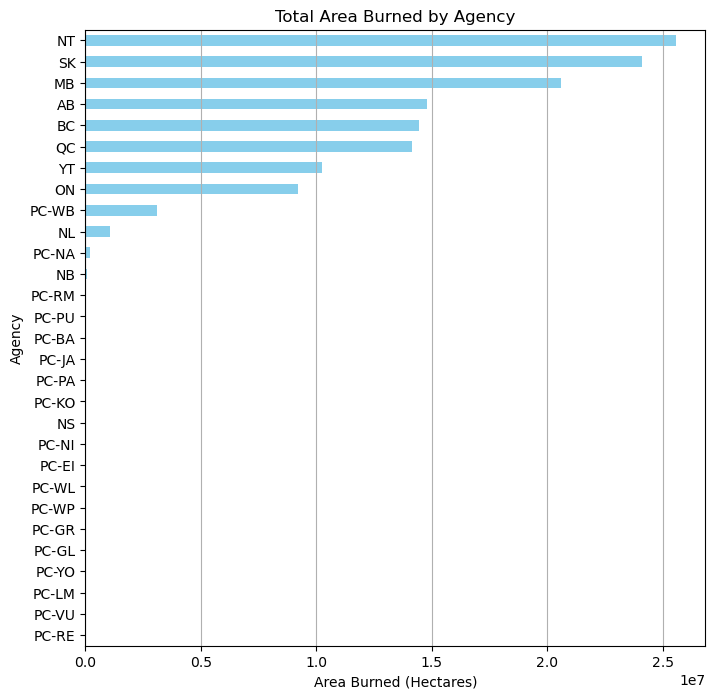

In [9]:
# Grouping by agency and calculating total CALC_HA for each agency
total_burned_per_agency = gdf.groupby('SRC_AGENCY')['CALC_HA'].sum().sort_values(ascending=True)

# Plotting
plt.figure(figsize=(8, 8))
total_burned_per_agency.plot(kind='barh', color='skyblue')
plt.title('Total Area Burned by Agency')
plt.xlabel('Area Burned (Hectares)')
plt.ylabel('Agency')
plt.grid(axis='x')
plt.show()

In [10]:
# Looking at climate indices
merged_df

,Date,ENSO,PDO
0,1948-01,0.26,-0.11
1,1948-02,0.43,-0.74
2,1948-03,0.72,-0.03
3,1948-04,0.21,-1.33
4,1948-05,0.24,-0.23
...,...,...,...
895,2022-08,-1.45,-9.90
896,2022-09,-1.79,-9.90
897,2022-10,-1.78,-9.90
898,2022-11,-0.63,-9.90


## Data Processing

In [11]:
# Reducing years to match climate indices
reduced_years_df = gdf[gdf['YEAR'] >= 1950]

# Filtering data for columns used in analysis
filter_df = reduced_years_df[['SRC_AGENCY', 'REP_DATE', 'CALC_HA']]

# Convert REP_DATE to datetime object
filter_df['REP_DATE'] = pd.to_datetime(filter_df['REP_DATE']).dt.to_period('M')

# Renaming column to have matching names for future merge
filter_df = filter_df.rename(columns={'REP_DATE' : 'Date'})

# Dropping Nan values for Date column
filter_df = filter_df.dropna(subset=['Date'])

# make a copy to use later in analysis 
all_agency = filter_df.copy()

In [12]:
filter_df = filter_df.groupby('Date').sum('CALC_HA')


In [13]:
# Initialize StandardScaler
scaler = StandardScaler()

# Reshape the 'CALC_HA' column to a 2D array (required by StandardScaler)
calc_ha_column = filter_df['CALC_HA'].values.reshape(-1, 1)

# Fit the scaler to the 'CALC_HA' column
scaler.fit(calc_ha_column)

# Transform the 'CALC_HA' column using the scaler
scaled_calc_ha = scaler.transform(calc_ha_column)

# Replace the 'CALC_HA' column in the DataFrame with the scaled values
filter_df['CALC_HA_scaled'] = scaled_calc_ha

In [14]:
filter_df.sort_values('CALC_HA_scaled', ascending=False)

,CALC_HA,CALC_HA_scaled
Date,,
1989-07,4.828603e+06,9.566118
1995-06,3.718404e+06,7.261989
2013-06,3.006597e+06,5.784689
1994-06,2.683605e+06,5.114346
2015-06,2.133208e+06,3.972041
...,...,...
1982-10,2.491864e+02,-0.454747
1975-04,2.454268e+02,-0.454754
2016-03,2.358355e+02,-0.454774


In [15]:
# Merging fire data and climate indices
full_merged_df = pd.merge(filter_df, merged_df, on='Date', how='left')

# Sorting values
full_merged_df = full_merged_df.sort_values(by='Date')

# Reset Index
full_merged_df.reset_index(inplace=True)

# Drop index
full_merged_df.drop(columns='index', inplace=True)

# Add Year and Month columns for regressor
full_merged_df['Year'] = full_merged_df['Date'].dt.year
full_merged_df['Month'] = full_merged_df['Date'].dt.month


In [16]:
full_merged_df

,Date,CALC_HA,CALC_HA_scaled,ENSO,PDO,Year,Month
0,1950-05,9094.679678,-0.436388,-1.22,-2.23,1950,5
1,1950-06,147001.768203,-0.150173,-1.69,-1.77,1950,6
2,1950-07,209573.639482,-0.020310,-1.69,-2.93,1950,7
3,1950-08,63968.216512,-0.322503,-0.96,-0.70,1950,8
4,1950-09,51780.695250,-0.347797,-0.95,-2.14,1950,9
...,...,...,...,...,...,...,...
470,2020-05,82032.002975,-0.285013,-0.40,0.09,2020,5
471,2020-06,87972.981147,-0.272683,0.07,-0.08,2020,6
472,2020-07,15641.348108,-0.422801,-0.26,-0.38,2020,7
473,2020-08,20849.844010,-0.411992,-1.19,-0.28,2020,8


### Filtering for BC's agency to compare models 

In [17]:
filtered_data_BC = all_agency[all_agency['SRC_AGENCY'] == 'BC']

# Groupby date and adding different events together for each agency
bc_data = filtered_data_BC.groupby('Date')['CALC_HA'].sum()

# Merging fire data and climate indices
bc_merged_data = pd.merge(bc_data, merged_df, on='Date', how='left')

# Sorting values
bc_merged_data = bc_merged_data.sort_values(by='Date')

# Add Year and Month columns for models
bc_merged_data['Year'] = bc_merged_data['Date'].dt.year
bc_merged_data['Month'] = bc_merged_data['Date'].dt.month

In [18]:
# Initialize StandardScaler
scaler = StandardScaler()

# Reshape the 'CALC_HA' column to a 2D array (required by StandardScaler)
calc_ha_column = bc_merged_data['CALC_HA'].values.reshape(-1, 1)

# Fit the scaler to the 'CALC_HA' column
scaler.fit(calc_ha_column)

# Transform the 'CALC_HA' column using the scaler
scaled_calc_ha = scaler.transform(calc_ha_column)

# Replace the 'CALC_HA' column in the DataFrame with the scaled values
bc_merged_data['CALC_HA_scaled'] = scaled_calc_ha

In [19]:
bc_merged_data

,Date,CALC_HA,ENSO,PDO,Year,Month,CALC_HA_scaled
0,1950-05,2048.606539,-1.22,-2.23,1950,5,-0.279721
1,1950-06,146686.220044,-1.69,-1.77,1950,6,1.284310
2,1950-07,124041.247771,-1.69,-2.93,1950,7,1.039440
3,1950-08,63968.216512,-0.96,-0.70,1950,8,0.389844
4,1950-09,51780.695250,-0.95,-2.14,1950,9,0.258054
...,...,...,...,...,...,...,...
322,2019-07,1953.151328,0.86,1.03,2019,7,-0.280753
323,2019-08,8085.258025,0.26,0.38,2019,8,-0.214444
324,2020-04,203.146805,0.35,-0.57,2020,4,-0.299676
325,2020-07,1159.789272,-0.26,-0.38,2020,7,-0.289332


In [20]:
# Lets look at the largest fire  months to try and reduce model error
large_fires = full_merged_df[full_merged_df['CALC_HA'] > 100000]

large_fires


,Date,CALC_HA,CALC_HA_scaled,ENSO,PDO,Year,Month
1,1950-06,147001.768203,-0.150173,-1.69,-1.77,1950,6
2,1950-07,209573.639482,-0.020310,-1.69,-2.93,1950,7
21,1953-07,247132.989131,0.057641,0.37,0.74,1953,7
32,1956-05,201473.533795,-0.037121,-1.04,-1.41,1956,5
45,1958-05,396582.541046,0.367812,1.16,1.28,1958,5
...,...,...,...,...,...,...,...
461,2018-07,984819.069069,1.588650,0.20,0.11,2018,7
462,2018-08,756690.544811,1.115187,0.49,0.18,2018,8
465,2019-05,812535.934693,1.231090,1.19,1.03,2019,5
466,2019-06,354399.187939,0.280264,0.90,1.09,2019,6


In [21]:
large_fires.shape

(164, 7)

<a id="eda"></a>


## Exploratory Data Analysis

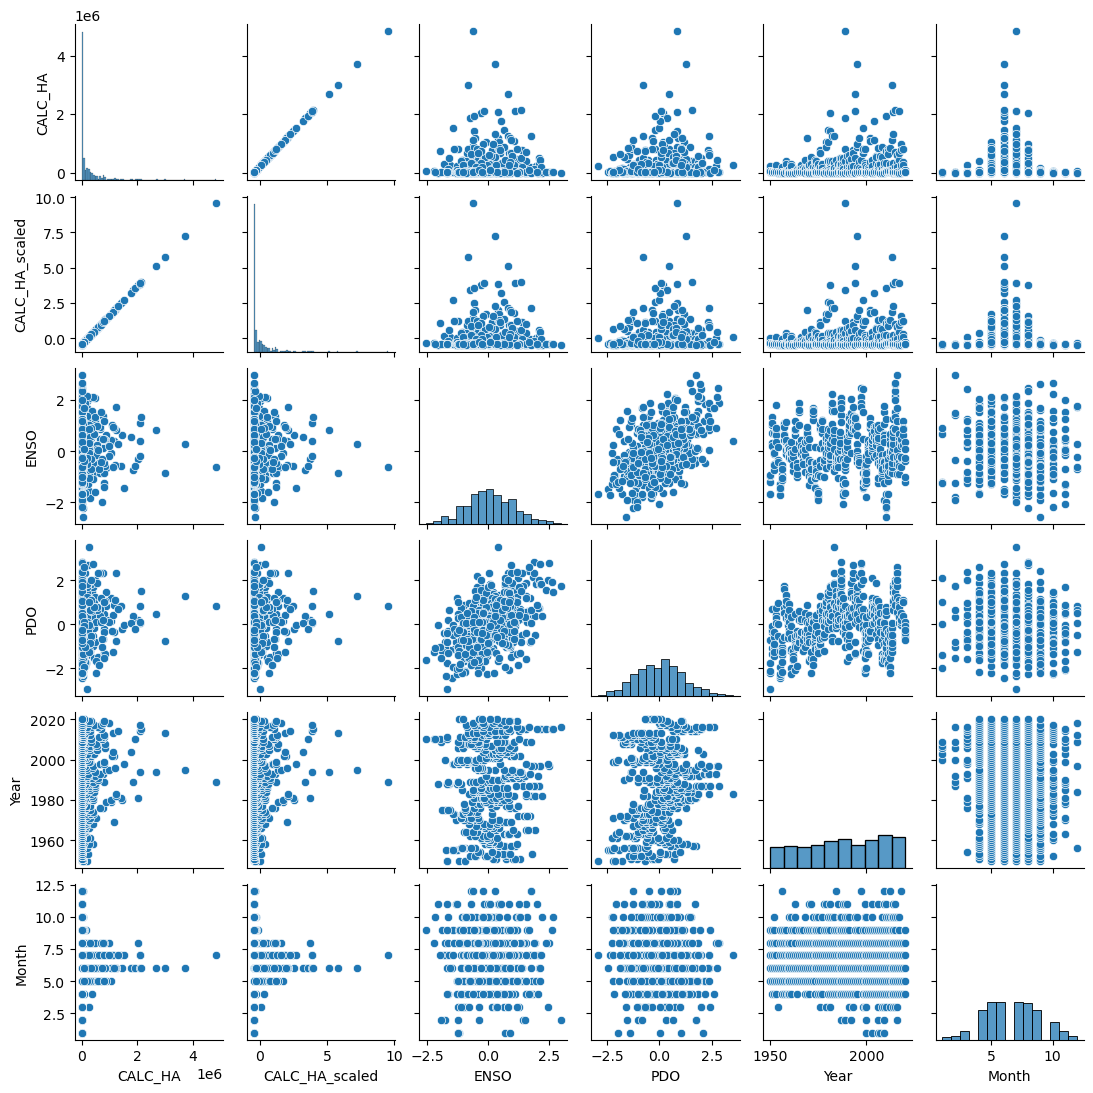

In [22]:
sns.pairplot(full_merged_df, height=1.85)

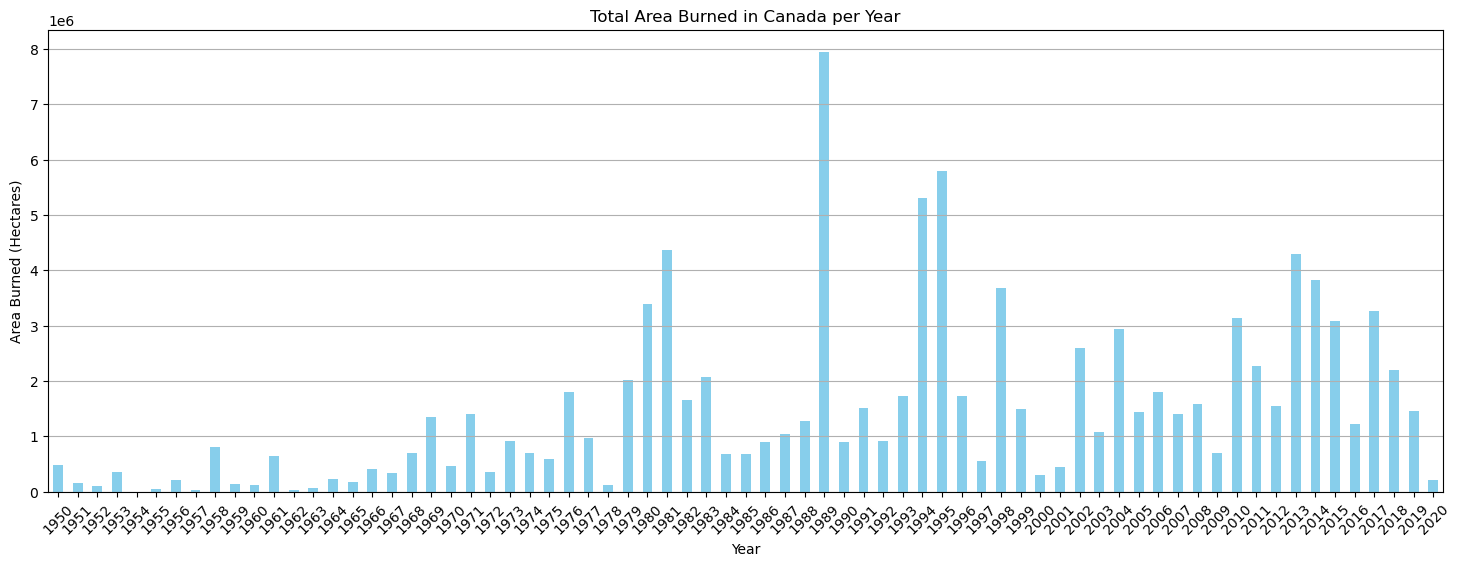

In [23]:
# Grouping by year and calculating total CALC_HA for each year
yearly_fire_totals = full_merged_df.groupby('Year')['CALC_HA'].sum()

# Plotting
plt.figure(figsize=(18, 6))
yearly_fire_totals.plot(kind='bar', color='skyblue')
plt.title('Total Area Burned in Canada per Year')
plt.xlabel('Year')
plt.ylabel('Area Burned (Hectares)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

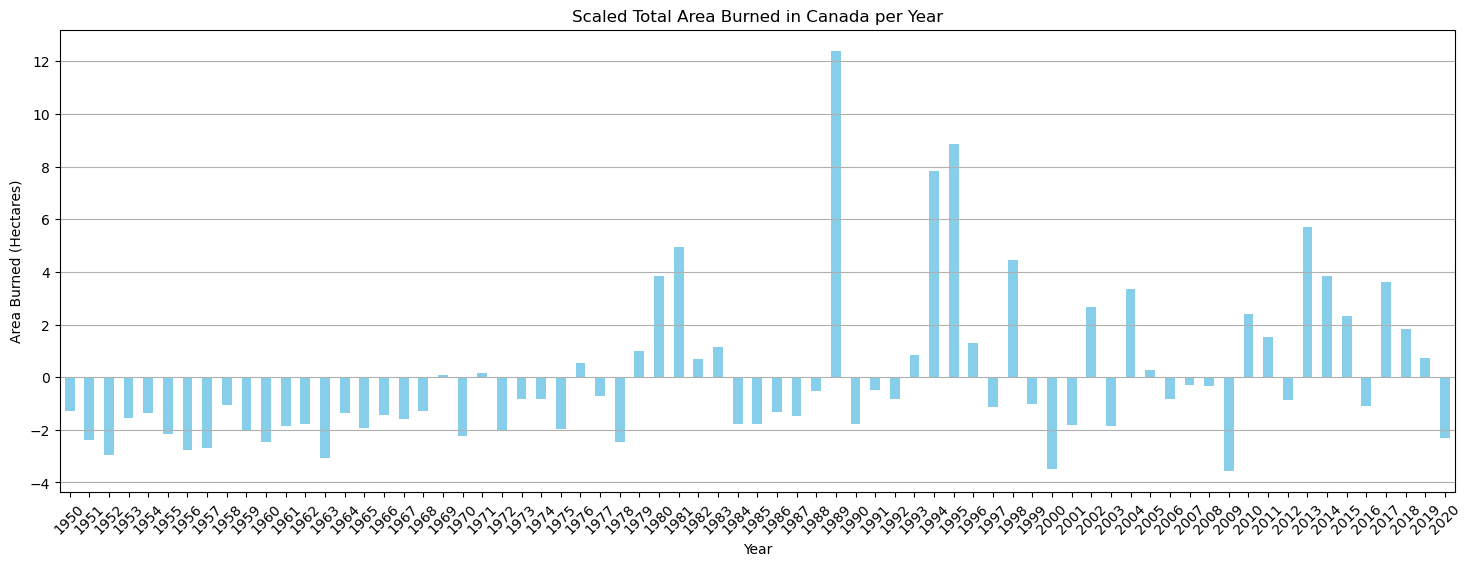

In [24]:
# Grouping by year and calculating total CALC_HA_scaled for each year
yearly_fire_totals = full_merged_df.groupby('Year')['CALC_HA_scaled'].sum()

# Plotting
plt.figure(figsize=(18, 6))
yearly_fire_totals.plot(kind='bar', color='skyblue')
plt.title('Scaled Total Area Burned in Canada per Year')
plt.xlabel('Year')
plt.ylabel('Area Burned (Hectares)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

<a id="model-construction"></a>

## Model Construction

### Lets first look at Linear Regression

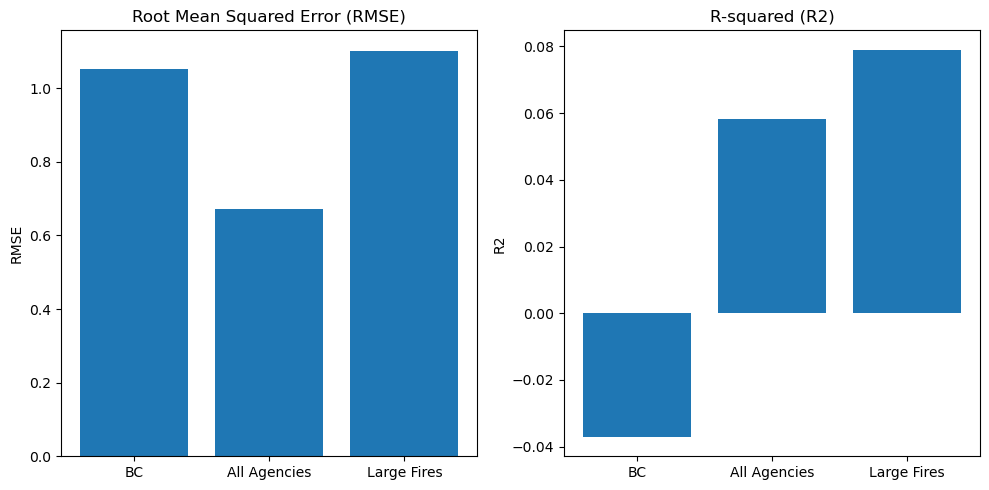

Model 1 (BC)
RMSE: 1.051343726316925
R2: -0.03711944531150113


Model 2 (All Agencies)
RMSE: 0.6719463913032905
R2: 0.058213109901063764


Model 3 (Large Fires)
RMSE: 1.1023688489595356
R2: 0.0790401605339135


In [25]:
# Data for first model
X = bc_merged_data[['ENSO', 'PDO', 'Year', 'Month']]
y = bc_merged_data['CALC_HA_scaled']

# Data for second model
Z = full_merged_df[['ENSO', 'PDO', 'Year', 'Month']]
t = full_merged_df['CALC_HA_scaled']

# Data for third model
J = large_fires[['ENSO', 'PDO', 'Year', 'Month']]
k = large_fires['CALC_HA_scaled']

# Split the data into training and testing sets for the first model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the first model (linear regression)
model1 = LinearRegression()
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)

# Compute evaluation metrics for the first model
mse1 = mean_squared_error(y_test, y_pred1)
rmse1 = np.sqrt(mse1)
r2_1 = r2_score(y_test, y_pred1)

# Split the data into training and testing sets for the second model
Z_train, Z_test, t_train, t_test = train_test_split(Z, t, test_size=0.2, random_state=42)

# Train the second model (linear regression)
model2 = LinearRegression()
model2.fit(Z_train, t_train)
t_pred2 = model2.predict(Z_test)

# Compute evaluation metrics for the second model
mse2 = mean_squared_error(t_test, t_pred2)
rmse2 = np.sqrt(mse2)
r2_2 = r2_score(t_test, t_pred2)

# Split the data into training and testing sets for the third model
J_train, J_test, k_train, k_test = train_test_split(J, k, test_size=0.2, random_state=42)

# Train the third model (linear regression)
model3 = LinearRegression()
model3.fit(J_train, k_train)
k_pred3 = model3.predict(J_test)

# Compute evaluation metrics for the third model
mse3 = mean_squared_error(k_test, k_pred3)
rmse3 = np.sqrt(mse3)
r2_3 = r2_score(k_test, k_pred3)

# Plot RMSE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(['BC', 'All Agencies', 'Large Fires'], [rmse1, rmse2, rmse3])
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')

# Plot R2
plt.subplot(1, 2, 2)
plt.bar(['BC', 'All Agencies', 'Large Fires'], [r2_1, r2_2, r2_3])
plt.title('R-squared (R2)')
plt.ylabel('R2')

plt.tight_layout()
plt.show()

# Print evaluation metrics for each model
print("Model 1 (BC)")
print("RMSE:", rmse1)
print("R2:", r2_1)
print("\n")

print("Model 2 (All Agencies)")
print("RMSE:", rmse2)
print("R2:", r2_2)
print("\n")

print("Model 3 (Large Fires)")
print("RMSE:", rmse3)
print("R2:", r2_3)

None of the models perform well based on the R2 values alone, Model 2 (All Agencies) performs relatively better compared to the other models. However, it's essential to further investigate and improve the models' performance, as indicated by the negative R2 values and the relatively high RMSE values.

### Now lets look at Random Forest Regressor to see if we can import model performance

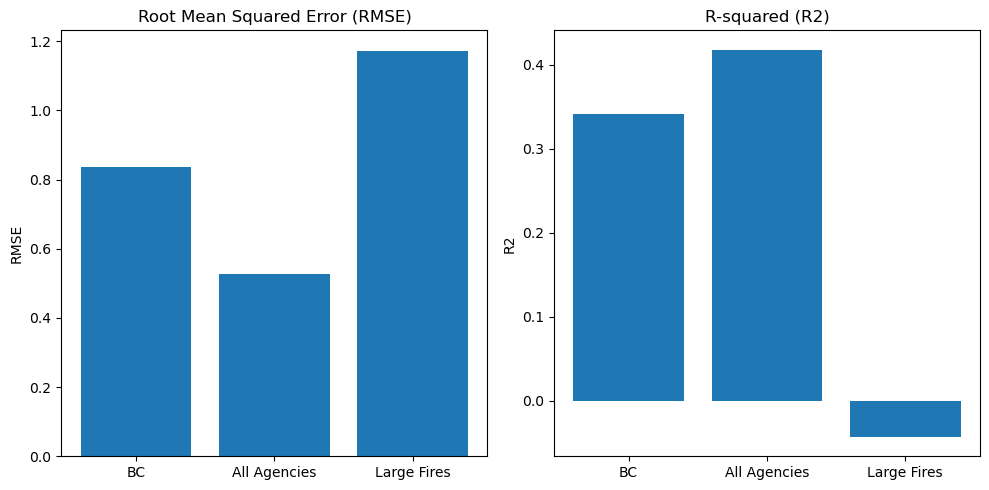

Model 1 (BC)
RMSE: 0.8376300361176149
R2: 0.3416697574747132


Model 2 (All Agencies)
RMSE: 0.5283336091171634
R2: 0.4177629123138552


Model 3 (Large Fires)
RMSE: 1.1731256167836195
R2: -0.042979720501611585


In [26]:
# Initialize the Random Forest regressor for the first model
rf_model1 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model1.fit(X_train, y_train)
y_pred_rf1 = rf_model1.predict(X_test)

# Compute evaluation metrics for the first model
mse_rf1 = mean_squared_error(y_test, y_pred_rf1)
rmse_rf1 = np.sqrt(mse_rf1)
r2_rf1 = r2_score(y_test, y_pred_rf1)

# Initialize the Random Forest regressor for the second model
rf_model2 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model2.fit(Z_train, t_train)
t_pred_rf2 = rf_model2.predict(Z_test)

# Compute evaluation metrics for the second model
mse_rf2 = mean_squared_error(t_test, t_pred_rf2)
rmse_rf2 = np.sqrt(mse_rf2)
r2_rf2 = r2_score(t_test, t_pred_rf2)

# Initialize the Random Forest regressor for the third model
rf_model3 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model3.fit(J_train, k_train)
k_pred_rf3 = rf_model3.predict(J_test)

# Compute evaluation metrics for the third model
mse_rf3 = mean_squared_error(k_test, k_pred_rf3)
rmse_rf3 = np.sqrt(mse_rf3)
r2_rf3 = r2_score(k_test, k_pred_rf3)

# Plot RMSE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(['BC', 'All Agencies', 'Large Fires'], [rmse_rf1, rmse_rf2, rmse_rf3])
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')

# Plot R2
plt.subplot(1, 2, 2)
plt.bar(['BC', 'All Agencies', 'Large Fires'], [r2_rf1, r2_rf2, r2_rf3])
plt.title('R-squared (R2)')
plt.ylabel('R2')

plt.tight_layout()
plt.show()

# Print evaluation metrics for each model
print("Model 1 (BC)")
print("RMSE:", rmse_rf1)
print("R2:", r2_rf1)
print("\n")

print("Model 2 (All Agencies)")
print("RMSE:", rmse_rf2)
print("R2:", r2_rf2)
print("\n")

print("Model 3 (Large Fires)")
print("RMSE:", rmse_rf3)
print("R2:", r2_rf3)

Model 2 (All Agencies) performs relatively better than the other models, as it has the highest R-squared value, indicating that it explains more of the variance in the area burned.

### Let's examine the model (Large Fires) that performed the best for linear regression and random forest regression, and conduct a Grid Search with 5 cross-validations to determine which parameters yield the best performance.

In [27]:
# Using the best model (All Agencies) to try to optimize R^2
Best_train = Z_train
best_train = t_train

Best_test = Z_test
best_test = t_test

In [ ]:
# Define parameter grid
param_grid = {
    'n_estimators': [200, 400, 600, 800, 1000],
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

# Create Random Forest
rf = RandomForestRegressor()

# Create GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='r2')

# Train the model for the large fire data
grid_search.fit(Best_train, best_train)

# Get the best parameters
best_params = grid_search.best_params_

print("Best Parameters:", best_params)

In [29]:
# Create a Random Forest regressor with the best parameters
best_rf_model = RandomForestRegressor(**best_params)

# Train the model on the training data
best_rf_model.fit(Best_train, best_train)

# Make predictions on the test set
y_pred_best = best_rf_model.predict(Best_test)

# Evaluate the model using the evaluation metrics
mse_best = mean_squared_error(best_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(best_test, y_pred_best)


### Additionally, we will employ a HistGradientBoostingRegressor model with grid search and 5-fold cross-validation. We will then compare its performance with the previous models

In [30]:
# Define parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 2, 4],
    'l2_regularization': [0.0, 0.1, 0.2]
}

# Initialize the HistGradientBoostingRegressor
hgb_model = HistGradientBoostingRegressor(random_state=42)

# Create GridSearchCV
grid_search_hgb = GridSearchCV(estimator=hgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Train the model
grid_search_hgb.fit(Best_train, best_train)

# Get the best parameters and best score
best_params_hgb = grid_search_hgb.best_params_
best_score_hgb = -grid_search_hgb.best_score_  

print("Best Parameters for HistGradientBoostingRegressor:", best_params_hgb)


Best Parameters for HistGradientBoostingRegressor: {'l2_regularization': 0.0, 'learning_rate': 0.01, 'max_depth': 3, 'max_iter': 300, 'min_samples_leaf': 2}


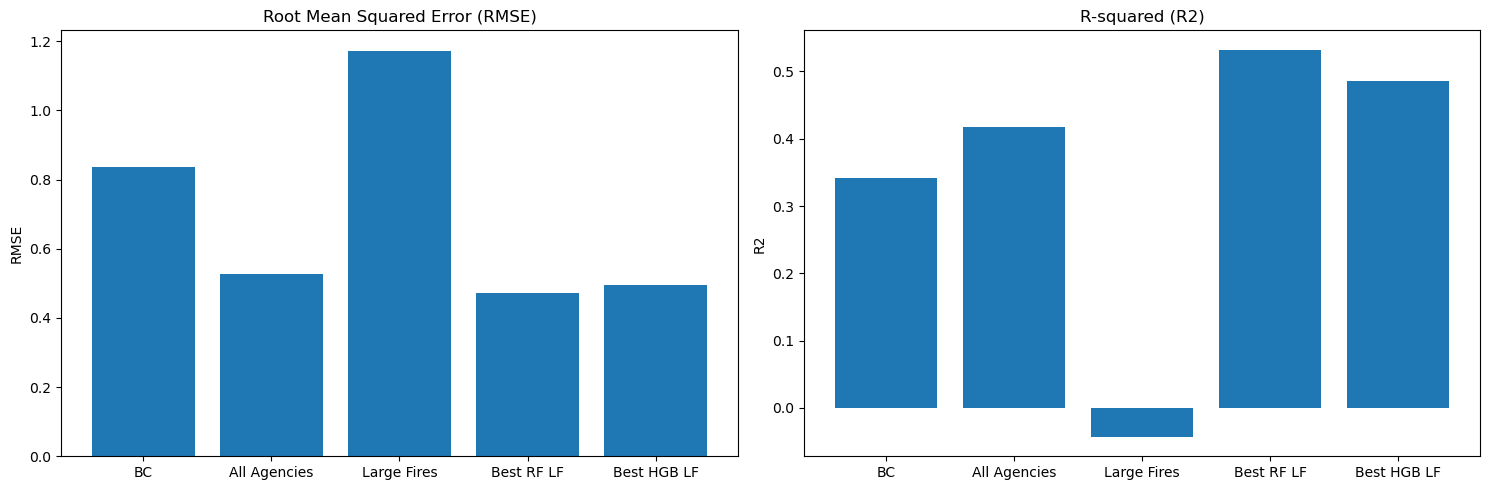

Model 1 (BC)
RMSE: 0.8376300361176149
R2: 0.3416697574747132


Model 2 (All Agencies)
RMSE: 0.5283336091171634
R2: 0.4177629123138552


Model 3 (Large Fires)
RMSE: 1.1731256167836195
R2: -0.042979720501611585


Random Forest Regression Metrics with Best Parameters:
RMSE: 0.47353298496211216
R2: 0.5322822399877798


HistGradientBoostingRegressor Metrics with Best Parameters:
RMSE: 0.49649865228799106
R2: 0.4858148416768756


In [31]:
# Rerun HistGradientBoostingRegressor with best parameters
best_hgb_model = HistGradientBoostingRegressor(**best_params_hgb)
best_hgb_model.fit(Best_train, best_train)
y_pred_best_hgb = best_hgb_model.predict(Best_test)

# Compute evaluation metrics for the best HistGradientBoostingRegressor model
mse_best_hgb = mean_squared_error(best_test, y_pred_best_hgb)
rmse_best_hgb = np.sqrt(mse_best_hgb)
r2_best_hgb = r2_score(best_test, y_pred_best_hgb)

# Plot RMSE
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
models = ['BC', 'All Agencies', 'Large Fires', 'Best RF LF', 'Best HGB LF']
rmses = [rmse_rf1, rmse_rf2, rmse_rf3, rmse_best, rmse_best_hgb]
plt.bar(models, rmses)
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')

# Plot R2
plt.subplot(1, 2, 2)
r2s = [r2_rf1, r2_rf2, r2_rf3, r2_best, r2_best_hgb]
plt.bar(models, r2s)
plt.title('R-squared (R2)')
plt.ylabel('R2')

plt.tight_layout()
plt.show()

# Print evaluation metrics for each model
print("Model 1 (BC)")
print("RMSE:", rmse_rf1)
print("R2:", r2_rf1)
print("\n")

print("Model 2 (All Agencies)")
print("RMSE:", rmse_rf2)
print("R2:", r2_rf2)
print("\n")

print("Model 3 (Large Fires)")
print("RMSE:", rmse_rf3)
print("R2:", r2_rf3)
print("\n")

print("Random Forest Regression Metrics with Best Parameters:")
print("RMSE:", rmse_best)
print("R2:", r2_best)
print("\n")

print("HistGradientBoostingRegressor Metrics with Best Parameters:")
print("RMSE:", rmse_best_hgb)
print("R2:", r2_best_hgb)

<a id="model-evaluation"></a>

### Model Evaluation 

- Random Forest Regression with Best Parameters: The R2 is positive, indicating some level of predictive capability, but the RMSE suggests relatively large errors in predictions.
- HistGradientBoostingRegressor with Best Parameters: This model seems to perform the best among the ones presented, with a higher R2 and lower RMSE compared to the others.

Overall, the HistGradientBoostingRegressor with the best parameters appears to be the best-performing model among the ones evaluated, as it has the highest R2 and relatively lower RMSE compared to the others.

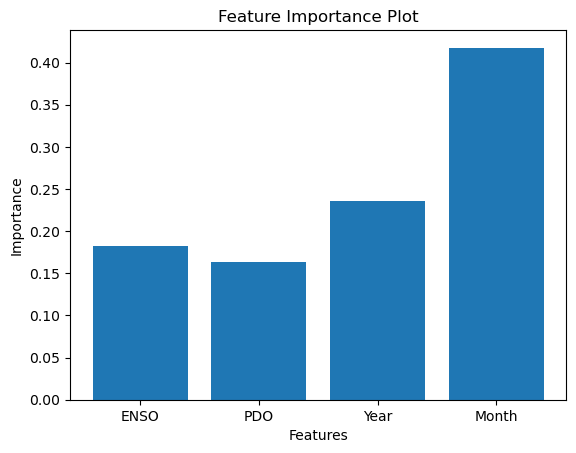

In [32]:
# Looking at feature importance for best model
importances = best_rf_model.feature_importances_
features = ['ENSO', 'PDO', 'Year', 'Month']
plt.bar(features, importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance Plot')
plt.show()

<a id="conclusion"></a>

## Conclusion


After analyzing the models and their respective performance metrics, several key observations emerge.

Firstly, Model 2 (All Agencies) outperforms the others, showcasing the highest R-squared value of approximately 0.42. This indicates that Model 2 explains a significant portion of the variance in the area burned, making it a valuable predictive tool. To optimize its performance, grid search with 5 cross-validations was employed, resulting in improved R-squared values of 0.53 for Random Forest Regression and 0.49 for HistGradientBoostingRegressor.

Moreover, examining feature importance reveals that the month of the year holds the most substantial influence on model predictions, with a feature importance score exceeding 40%. Following closely is the year, contributing approximately 25% to the model's predictive power. Additionally, ENSO and PDO variables exhibit moderate importance, with scores of approximately 20% and 15%, respectively.

In future analyses, aggregating data per season rather than per month could enhance model performance. This approach may capture more significant trends and patterns in wildfire occurrence, thereby improving predictive capabilities.

Both Random Forest Regression and HistGradientBoostingRegressor demonstrate promising results with relatively low RMSE values and respectable R-squared scores. Random Forest Regression achieves an RMSE of approximately 0.476 and an R-squared value of around 0.528, indicating robust predictive performance. Similarly, HistGradientBoostingRegressor yields an RMSE of approximately 0.496 and an R-squared value of approximately 0.486, highlighting its effectiveness in predicting area burned by wildfires.

In conclusion, Model 2 (All Agencies) emerges as the most effective in explaining the variance in the area burned by wildfires. Further exploration of seasonal data aggregation, considering the significant influence of month and year variables, may provide valuable insights for enhancing predictive modeling efforts in wildfire management and mitigation strategies.